# Dartsの公式サイトのexample
https://unit8co.github.io/darts/examples/darts-intro.html

In [2]:
import sys
import pandas as pd
import numpy as np
from datetime import datetime
import time
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    StandardRegressionModel,
    Theta,
    FFT
)
from darts.metrics import mape, mase
# from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## データの読み込み

In [3]:
df = pd.read_csv('../data/AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])

In [5]:
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


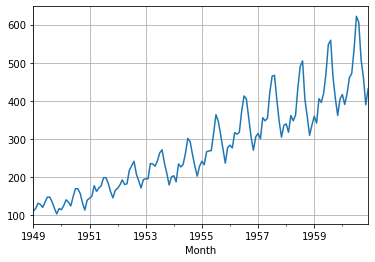

In [6]:
fig, ax = plt.subplots()
series.plot(ax=ax)
ax.grid()

## train & validation

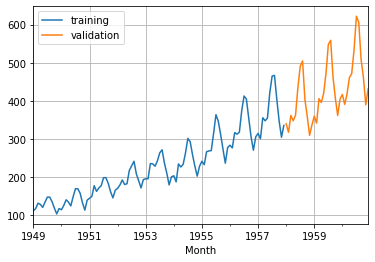

In [7]:
train, val = series.split_before(pd.Timestamp('19580101'))

fig, ax = plt.subplots()
train.plot(label='training', ax=ax)
val.plot(label='validation', ax=ax)
ax.legend(loc='best')
ax.grid()

## Toy model

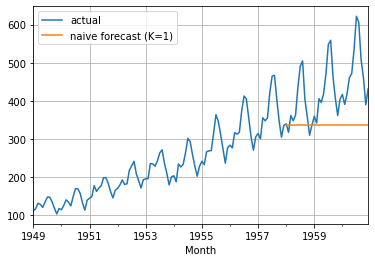

In [9]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train)
naive_forecast = naive_model.predict(len(val))

fig, ax = plt.subplots()
series.plot(label='actual', ax=ax)
naive_forecast.plot(label='naive forecast (K=1)', ax=ax)
ax.legend(loc='best')
ax.grid()

In [10]:
help(NaiveSeasonal)

Help on class NaiveSeasonal in module darts.models.baselines:

class NaiveSeasonal(darts.models.forecasting_model.UnivariateForecastingModel)
 |  NaiveSeasonal(K: int = 1)
 |  
 |  The base class for univariate forecasting models.
 |  
 |  Method resolution order:
 |      NaiveSeasonal
 |      darts.models.forecasting_model.UnivariateForecastingModel
 |      darts.models.forecasting_model.ForecastingModel
 |      abc.ABC
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, K: int = 1)
 |      Naive Seasonal Model
 |      
 |      This model always predicts the value of `K` time steps ago.
 |      When :math:`K=1`, this model predicts the last value of the training set.
 |      When :math:`K>1`, it repeats the last :math:`K` values of the training set.
 |      
 |      Parameters
 |      ----------
 |      K
 |          the number of last time steps of the training set to repeat
 |  
 |  __str__(self)
 |      Return str(self).
 |  
 |  fit(self, series: darts.t

訓練データの最後(K=1)の値を繰り返すだけのモデル

## 季節による周期性

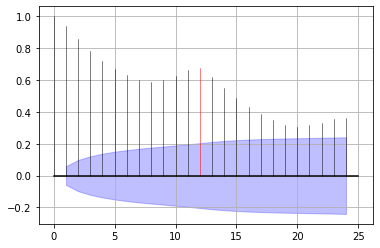

In [14]:
fig, ax = plt.subplots()
plot_acf(train, m=12, alpha=.05, axis=ax)
ax.grid()

m=12でピークが出ているので、12個ずつの周期があるといえる<br/>
青いゾーンより大きいので有意

正しくない周期の場合

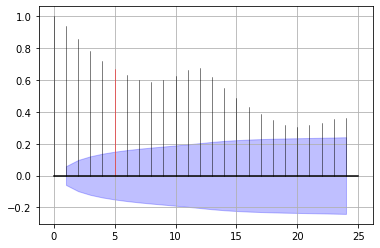

In [15]:
fig, ax = plt.subplots()
plot_acf(train, m=5, alpha=.05, axis=ax)
ax.grid()

mで指定したところが赤線に変わるだけ<br/>
計算内容が変わるわけではない

## もう少しましなToy model

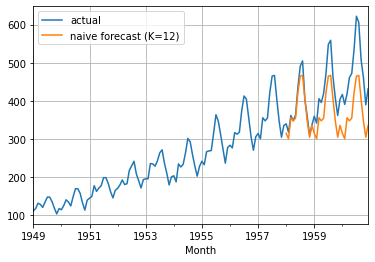

In [16]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train)
seasonal_forecast = seasonal_model.predict(len(val))

fig, ax = plt.subplots()
series.plot(label='actual')
seasonal_forecast.plot(label='naive forecast (K=12)')
ax.grid()
ax.legend(loc='best')

訓練データの最後の12個を繰り返す<br/>
トレンドの分でずれている

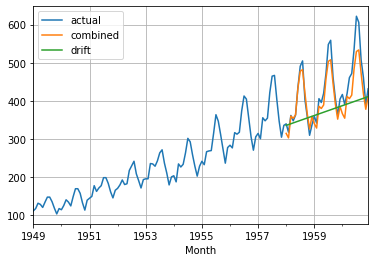

In [17]:
drift_model = NaiveDrift()
drift_model.fit(train)
drift_forecast = drift_model.predict(36)

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

fig, ax = plt.subplots()
series.plot(label='actual')
combined_forecast.plot(label='combined')
drift_forecast.plot(label='drift')
ax.grid()
ax.legend(loc='best')

ナイーブなトレンドを予測に追加した<br/>
結構いい感じ

In [18]:
print("Mean absolute percentage error for the combined naive drift + seasonal: {:.2f}%.".format(mape(series, combined_forecast)))

Mean absolute percentage error for the combined naive drift + seasonal: 5.77%.


## いくつかモデルを試す

In [19]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print('model {} obtains MAPE: {:.2f}%'.format(model, mape(val, forecast)))

eval_model(ExponentialSmoothing())
eval_model(Prophet())
eval_model(AutoARIMA())
eval_model(Theta())

model Exponential smoothing obtains MAPE: 5.11%
model Prophet obtains MAPE: 9.78%
model Auto-ARIMA obtains MAPE: 11.65%
model Theta(0) obtains MAPE: 8.15%


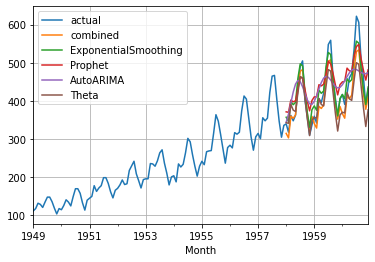

In [20]:
es = ExponentialSmoothing()
es.fit(train)
es_forecast = es.predict(len(val))

prophet = Prophet()
prophet.fit(train)
prophet_forecast = prophet.predict(len(val))

aa = AutoARIMA()
aa.fit(train)
aa_forecast = aa.predict(len(val))

theta = Theta()
theta.fit(train)
theta_forecast = theta.predict(len(val))

fig, ax = plt.subplots()
series.plot(label='actual')
combined_forecast.plot(label='combined')
es_forecast.plot(label='ExponentialSmoothing')
prophet_forecast.plot(label='Prophet')
aa_forecast.plot(label='AutoARIMA')
theta_forecast.plot(label='Theta')
ax.grid()
ax.legend(loc='best')

ExponentialSmoothing以外は山と谷にしっかりフィットできていない